In [88]:
import pandas as pd
import geoplot as gplt
import numpy as np
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import geopandas as gpd
import pycountry
import descartes
import contextily as ctx
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.font_manager import FontProperties

In [89]:
df = pd.read_csv("./dnrpa-robos-recuperos-autos-202005.csv", delimiter=",", decimal=",", encoding="utf-8")

In [90]:
df.head()

,tramite_tipo,tramite_fecha,fecha_inscripcion_inicial,registro_seccional_codigo,registro_seccional_descripcion,registro_seccional_provincia,automotor_origen,automotor_anio_modelo,automotor_tipo_codigo,automotor_tipo_descripcion,...,automotor_uso_descripcion,titular_tipo_persona,titular_domicilio_localidad,titular_domicilio_provincia,titular_genero,titular_anio_nacimiento,titular_pais_nacimiento,titular_porcentaje_titularidad,titular_domicilio_provincia_id,titular_pais_nacimiento_id
0,DENUNCIA DE ROBO O HURTO / RETENCION INDEBIDA,2020-05-22,2000-04-26,1047,LANUS Nº 1,Buenos Aires,Nacional,2000.0,NaN,FURGON 3000,...,Privado,Jurídica,LANUS,BUENOS AIRES,No aplica,2017,No aplica,100,6,NaN
1,DENUNCIA DE ROBO O HURTO / RETENCION INDEBIDA,2020-05-05,1998-03-25,1053,LOMAS DE ZAMORA Nº 1,Buenos Aires,Nacional,1998.0,NaN,SEDAN,...,Privado,Física,TEMPERLEY,BUENOS AIRES,No identificado,1992,ARGENTINA,100,6,ARG
2,DENUNCIA DE ROBO O HURTO / RETENCION INDEBIDA,2020-05-06,2010-10-29,1094,TANDIL Nº 1,Buenos Aires,Nacional,2010.0,NaN,SEMIRREMOLQUE VOLCAD TRASERO,...,Privado,Jurídica,TANDIL,BUENOS AIRES,No aplica,2009,No aplica,100,6,NaN
3,DENUNCIA DE ROBO O HURTO / RETENCION INDEBIDA,2020-05-18,1999-02-17,1120,LA MATANZA Nº 03,Buenos Aires,Nacional,1999.0,NaN,SEDAN,...,Privado,Física,LA TABLADA,BUENOS AIRES,No identificado,1971,ARGENTINA,100,6,ARG
4,DENUNCIA DE ROBO O HURTO / RETENCION INDEBIDA,2020-05-08,1994-02-25,1122,LOMAS DE ZAMORA Nº 2,Buenos Aires,Nacional,1994.0,NaN,BERLINA 5 PTAS,...,Privado,Física,LOMAS DE ZAMORA,BUENOS AIRES,Femenino,1967,ARGENTINA,100,6,ARG


In [91]:
df.columns

Index(['tramite_tipo', 'tramite_fecha', 'fecha_inscripcion_inicial',
       'registro_seccional_codigo', 'registro_seccional_descripcion',
       'registro_seccional_provincia', 'automotor_origen',
       'automotor_anio_modelo', 'automotor_tipo_codigo',
       'automotor_tipo_descripcion', 'automotor_marca_codigo',
       'automotor_marca_descripcion', 'automotor_modelo_codigo',
       'automotor_modelo_descripcion', 'automotor_uso_codigo',
       'automotor_uso_descripcion', 'titular_tipo_persona',
       'titular_domicilio_localidad', 'titular_domicilio_provincia',
       'titular_genero', 'titular_anio_nacimiento', 'titular_pais_nacimiento',
       'titular_porcentaje_titularidad', 'titular_domicilio_provincia_id',
       'titular_pais_nacimiento_id'],
      dtype='object')

In [92]:
df['cantidad'] = 1

In [93]:
df_year_model = df.groupby(['tramite_fecha', 'automotor_anio_modelo'], as_index=False).agg({'cantidad': 'sum'})

df_address_model = df.groupby(['tramite_fecha', 'titular_domicilio_localidad'], as_index=False).agg({'cantidad': 'sum'})

df_gender = df.groupby(['titular_genero'], as_index=False).agg({'cantidad': 'sum'})

df_year_origin = df.groupby(['tramite_fecha', 'automotor_origen'], as_index=False).agg({'cantidad': 'sum'}) #protocolo 21 son los de brasil

In [94]:
nac = df_year_origin.loc[df_year_origin['automotor_origen'] == 'Nacional']
imp = df_year_origin.loc[df_year_origin['automotor_origen'] == 'Importado']
pro = df_year_origin.loc[df_year_origin['automotor_origen'] == 'Protocolo 21']
no_nac = pd.merge(imp, pro, on='tramite_fecha', how='inner')
no_nac['automotor_origen'] = 'No Nacional'
no_nac['cantidad'] = no_nac['cantidad_x'] + no_nac['cantidad_y']

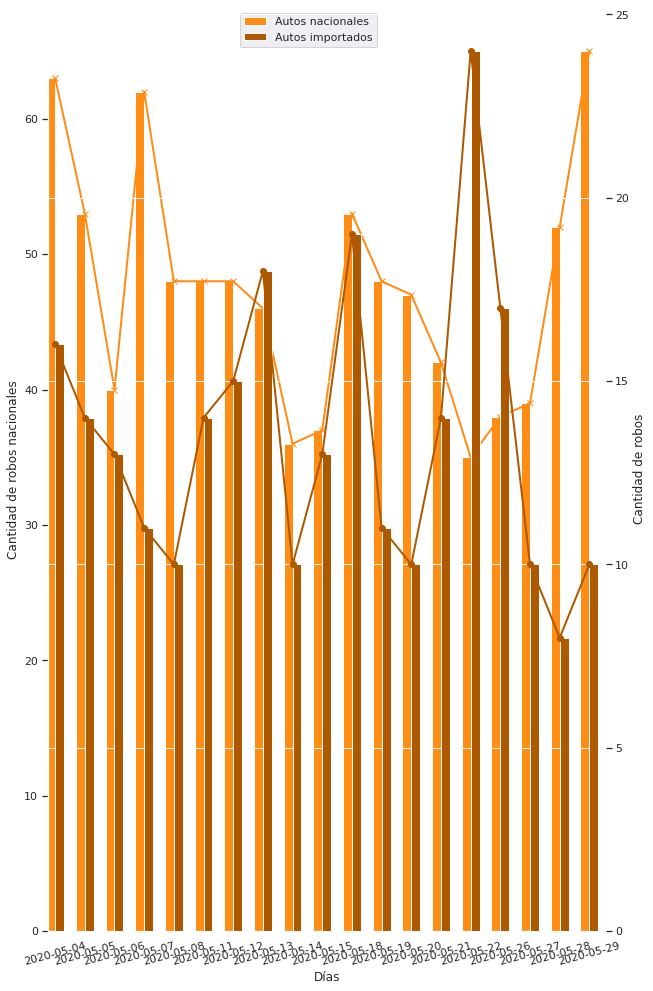

In [121]:
fig = plt.figure(figsize=(10,17)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

nac.plot(x='tramite_fecha', y='cantidad', kind='bar', color='#FF8C15', ax=ax, width=width, position=1, rot=15, label='Autos nacionales',  legend=False)
imp.plot(x='tramite_fecha', y='cantidad', kind='bar', color='#AE5800', ax=ax2, width=width, position=0, rot=15, label='Autos importados', legend=False)

ax.set_title("", size=14)
ax.set_facecolor('white')
ax.set_ylabel('Cantidad de robos nacionales')
ax.set_xlabel('Días')
ax.plot(nac['tramite_fecha'],nac['cantidad'], linestyle='-', marker='x', linewidth=2.0, color='#FF8C15')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, loc='best', bbox_to_anchor=(0.6, 1.0))
ax2.set_facecolor('white')
ax2.set_ylabel('Cantidad de robos')
ax2.plot(ax.get_xticks(),imp['cantidad'], linestyle='-', marker='o', linewidth=2.0, color='#AE5800')

plt.box(on=None)
plt.savefig('./peor_grafica.png')
plt.show()

In [126]:
imp['cantidad'].min()

8

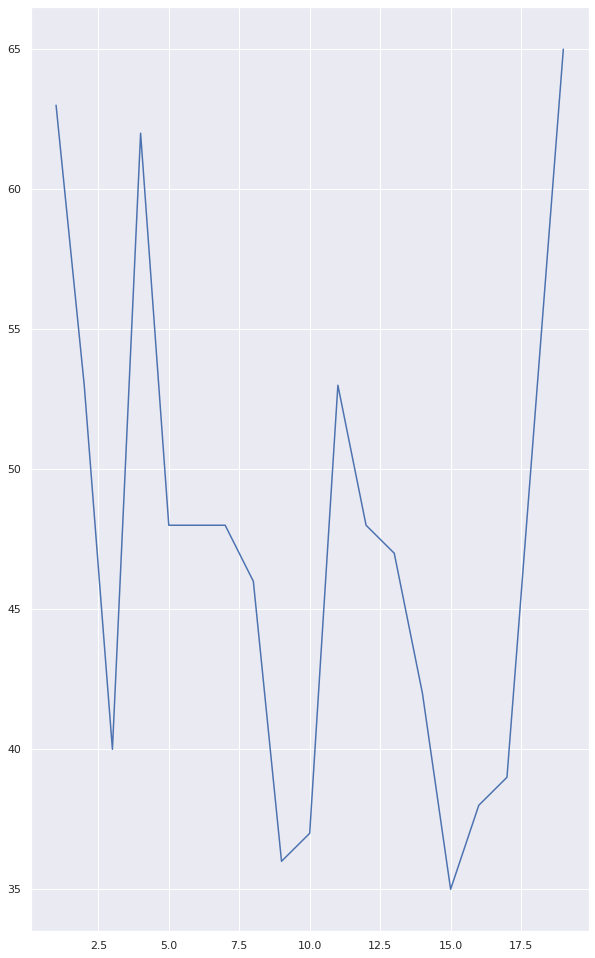

In [108]:
from scipy.interpolate import make_interp_spline, BSpline

fig = plt.figure(figsize=(10,17))
# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(1, 19, 19) 

spl = make_interp_spline(xnew, nac['cantidad'], k=9)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()